In [1]:
import tensorflow as tf
import keras 
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from keras import regularizers
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
demographics = pd.read_csv('Demographics-new.csv')
demographics.head()

,Unnamed: 0,SUBJECT_ID,GENDER,DOB,DOD,DOA,ADMIT_AGE,ETHNICITY,MARITAL_STATUS,LANGUAGE,...,VALUENUM-8-7-6-5-4-3-2,ITEMID-3,VALUENUM-8-7-6-5-4-3,ITEMID,VALUENUM-8-7-6-5-4,VALUENUM-8-7-6-5,VALUENUM-8-7-6,VALUENUM-8-7,VALUENUM-8,VALUENUM
0,10,31,M,2036-05-17,2108-08-30 00:00:00,2108-08-22 23:27:00,72.312329,WHITE,MARRIED,UKNOWN,...,0.0,0.0,0.0,0.0,0.0,13.3,33.9,11.0,26.3,260.0
1,14,56,F,1804-01-02,2104-01-08 00:00:00,2104-01-02 02:01:00,NaN,WHITE,UKNOWN,UKNOWN,...,0.0,0.0,0.0,0.0,0.0,13.2,24.5,7.1,8.2,124.0
2,207,61,M,2063-10-21,2119-02-03 00:00:00,2119-01-04 18:12:00,55.241096,WHITE,MARRIED,UKNOWN,...,0.0,0.0,0.0,0.0,0.0,12.2,13.1,4.2,0.4,11.0
3,208,67,M,2084-06-05,2157-12-02 00:00:00,2157-12-02 00:45:00,73.539726,WHITE,SINGLE,UKNOWN,...,0.0,0.0,0.0,0.0,0.0,13.2,54.1,18.4,9.3,183.0
4,214,84,F,2151-10-21,2196-04-17 00:00:00,2196-04-14 04:02:00,44.512329,WHITE,MARRIED,UKNOWN,...,0.0,0.0,0.0,0.0,0.0,12.9,36.3,12.6,7.1,262.0


In [3]:
demographics.fillna(0, inplace=True) 

In [4]:
# Define AKI diagnoses from non-AKI diagnoses
aki_pre = demographics[demographics['OLD_FLAG']==0]
aki_pos = aki_pre[aki_pre['AKI_DIAGNOSIS_FLAG']== 1]
aki_neg = aki_pre[aki_pre['AKI_DIAGNOSIS_FLAG']==0]

# Clean data sets
del aki_neg['CAUSE']
del aki_pos['CAUSE']

del aki_neg['AKI_DIAGNOSIS_FLAG']
del aki_pos['AKI_DIAGNOSIS_FLAG']

del aki_neg['OLD_FLAG']
del aki_pos['OLD_FLAG']

del aki_neg['OUTSIDE_DEATH_FLAG']
del aki_pos['OUTSIDE_DEATH_FLAG']

del aki_neg['SUBJECT_ID']
del aki_pos['SUBJECT_ID']

del aki_neg['DOB']
del aki_pos['DOB']

del aki_neg['DOD']
del aki_pos['DOD']

In [5]:
aki_pos['DOA']
del aki_pos['DOA']
del aki_neg['DOA']

del aki_pos['delta']
del aki_pos['ITEMID']
del aki_pos['ITEMID-3']
del aki_pos['ITEMID-3-2']
del aki_pos['ITEMID-3-2-1']




del aki_pos['Unnamed: 0']

aki_pos.head()



,GENDER,ADMIT_AGE,ETHNICITY,MARITAL_STATUS,LANGUAGE,RELIGION,INSURANCE,ADMISSION_LOCATION,#ADMISSIONS,DEATH_FLAG,...,LIVER_FLAG,VALUENUM-8-7-6-5-4-3-2-1,VALUENUM-8-7-6-5-4-3-2,VALUENUM-8-7-6-5-4-3,VALUENUM-8-7-6-5-4,VALUENUM-8-7-6-5,VALUENUM-8-7-6,VALUENUM-8-7,VALUENUM-8,VALUENUM
10,M,80.564384,OTHER,SINGLE,UKNOWN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1,1,...,0,0.7,0.0,0.0,0.0,13.0,25.5,9.1,3.4,144.0
31,M,79.989041,WHITE,MARRIED,UKNOWN,JEWISH,Medicare,EMERGENCY ROOM ADMIT,1,1,...,0,2.2,0.0,0.0,0.0,18.2,30.4,10.7,15.3,128.0
32,M,76.687671,WHITE,SINGLE,UKNOWN,EPISCOPALIAN,Medicare,CLINIC REFERRAL/PREMATURE,1,1,...,0,4.6,0.0,0.0,0.0,20.2,26.7,8.7,5.5,135.0
34,M,50.520548,WHITE,MARRIED,ENGL,PROTESTANT QUAKER,Private,CLINIC REFERRAL/PREMATURE,2,1,...,0,0.7,0.0,0.0,0.0,13.8,20.4,6.5,25.5,230.0
52,F,66.019178,HISPANIC OR LATINO,SEPARATED,UKNOWN,CATHOLIC,Medicare,EMERGENCY ROOM ADMIT,1,1,...,0,3.3,0.0,0.0,0.0,14.3,30.2,9.7,8.8,145.0


In [6]:
# Create Outcome data sets
aki_sepsis = pd.Series(aki_pos['KIDNEY_FAILURE_FLAG'])
aki_death = pd.Series(aki_pos['DEATH_FLAG'])

In [7]:
aki_pos.head()

,GENDER,ADMIT_AGE,ETHNICITY,MARITAL_STATUS,LANGUAGE,RELIGION,INSURANCE,ADMISSION_LOCATION,#ADMISSIONS,DEATH_FLAG,...,LIVER_FLAG,VALUENUM-8-7-6-5-4-3-2-1,VALUENUM-8-7-6-5-4-3-2,VALUENUM-8-7-6-5-4-3,VALUENUM-8-7-6-5-4,VALUENUM-8-7-6-5,VALUENUM-8-7-6,VALUENUM-8-7,VALUENUM-8,VALUENUM
10,M,80.564384,OTHER,SINGLE,UKNOWN,OTHER,Medicare,EMERGENCY ROOM ADMIT,1,1,...,0,0.7,0.0,0.0,0.0,13.0,25.5,9.1,3.4,144.0
31,M,79.989041,WHITE,MARRIED,UKNOWN,JEWISH,Medicare,EMERGENCY ROOM ADMIT,1,1,...,0,2.2,0.0,0.0,0.0,18.2,30.4,10.7,15.3,128.0
32,M,76.687671,WHITE,SINGLE,UKNOWN,EPISCOPALIAN,Medicare,CLINIC REFERRAL/PREMATURE,1,1,...,0,4.6,0.0,0.0,0.0,20.2,26.7,8.7,5.5,135.0
34,M,50.520548,WHITE,MARRIED,ENGL,PROTESTANT QUAKER,Private,CLINIC REFERRAL/PREMATURE,2,1,...,0,0.7,0.0,0.0,0.0,13.8,20.4,6.5,25.5,230.0
52,F,66.019178,HISPANIC OR LATINO,SEPARATED,UKNOWN,CATHOLIC,Medicare,EMERGENCY ROOM ADMIT,1,1,...,0,3.3,0.0,0.0,0.0,14.3,30.2,9.7,8.8,145.0


In [8]:
# Get dummies
aki_pos = pd.get_dummies(aki_pos, columns=['GENDER','ETHNICITY','MARITAL_STATUS', 'LANGUAGE', 'RELIGION', 'INSURANCE', 'ADMISSION_LOCATION'])

In [9]:
del aki_pos['DEATH_FLAG']

In [10]:
aki_pos.head()

,ADMIT_AGE,#ADMISSIONS,CANCER_FLAG,KIDNEY_FAILURE_FLAG,HYPO_FLAG,SHOCK_FLAG,ANEMIA_FLAG,HEMO_FLAG,ACID_FLAG,LIVER_FLAG,...,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR
10,80.564384,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
31,79.989041,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
32,76.687671,1,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
34,50.520548,2,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
52,66.019178,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [11]:
print(len(aki_pos))

2159


In [12]:
# Check outcome numbers
print(aki_sepsis.value_counts())
print(aki_death.value_counts())

0    1998
1     161
Name: KIDNEY_FAILURE_FLAG, dtype: int64
1    1208
0     951
Name: DEATH_FLAG, dtype: int64


In [43]:
# Normalize data
from sklearn import preprocessing
aki_pos1 = preprocessing.minmax_scale(aki_pos)


In [159]:
# Test/ train 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(aki_pos1, aki_death, test_size=0.2, random_state=42)

In [166]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import matplotlib.pyplot as plt
fs1 = SelectKBest(score_func=chi2, k=10)
fs2 = SelectKBest(score_func=chi2, k=15)
fs3 = SelectKBest(score_func=chi2, k=20)
fs4 = SelectKBest(score_func=chi2, k=25)
fs5 = SelectKBest(score_func=chi2, k=30)
fs6 = SelectKBest(score_func=chi2, k=35)
fs7 = SelectKBest(score_func=chi2, k=40)

In [167]:
fs1.fit(X_train, y_train)
X_train1 = fs1.transform(X_train)
X_test1 = fs1.transform(X_test)

fs2.fit(X_train, y_train)
X_train2 = fs2.transform(X_train)
X_test2 = fs2.transform(X_test)

fs3.fit(X_train, y_train)
X_train3 = fs3.transform(X_train)
X_test3 = fs3.transform(X_test)

fs4.fit(X_train, y_train)
X_train4 = fs4.transform(X_train)
X_test4 = fs4.transform(X_test)

fs5.fit(X_train, y_train)
X_train5 = fs5.transform(X_train)
X_test5 = fs5.transform(X_test)

fs6.fit(X_train, y_train)
X_train6 = fs6.transform(X_train)
X_test6 = fs6.transform(X_test)

fs7.fit(X_train, y_train)
X_train7 = fs7.transform(X_train)
X_test7 = fs7.transform(X_test)

In [207]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy
# fix random seed for reproducibility
numpy.random.seed(0)

In [208]:
# Do all 7 models for each number of feathers
model7 = Sequential()

model7.add(Dense(80, input_shape=(40,), kernel_regularizer=regularizers.l2(0.2), activation = 'relu'))
model7.add(Dropout(0.3))
model7.add(Dense(60, activation = 'relu'))
model7.add(Dropout(0.3))
model7.add(Dense(40, activation = 'relu'))
model7.add(Dropout(0.3))
model7.add(Dense(20, activation = 'relu'))
model7.add(Dropout(0.3))
model7.add(Dense(1, activation = 'sigmoid'))

In [209]:
# Compile models
model7.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [211]:
model7.fit(X_train7, y_train, batch_size=20, epochs=250, verbose=1, validation_data=(X_test7, y_test), shuffle=True)

Train on 1727 samples, validate on 432 samples
Epoch 1/250
1727/1727 [==============================] - 2s 985us/step - loss: 6.8762 - accuracy: 0.5657 - val_loss: 3.6411 - val_accuracy: 0.5972
Epoch 2/250
1727/1727 [==============================] - 1s 361us/step - loss: 2.2627 - accuracy: 0.6161 - val_loss: 1.3413 - val_accuracy: 0.6412
Epoch 3/250
1727/1727 [==============================] - 1s 412us/step - loss: 1.0002 - accuracy: 0.6271 - val_loss: 0.7800 - val_accuracy: 0.6551
Epoch 4/250
1727/1727 [==============================] - 0s 273us/step - loss: 0.7076 - accuracy: 0.6561 - val_loss: 0.6611 - val_accuracy: 0.6528
Epoch 5/250
1727/1727 [==============================] - 0s 251us/step - loss: 0.6507 - accuracy: 0.6589 - val_loss: 0.6376 - val_accuracy: 0.6736
Epoch 6/250
1727/1727 [==============================] - 0s 237us/step - loss: 0.6457 - accuracy: 0.6624 - val_loss: 0.6490 - val_accuracy: 0.6505
Epoch 7/250
1727/1727 [==============================] - 0s 184us/step 

1727/1727 [==============================] - 0s 212us/step - loss: 0.5935 - accuracy: 0.6873 - val_loss: 0.6280 - val_accuracy: 0.6713
Epoch 57/250
1727/1727 [==============================] - 0s 202us/step - loss: 0.5865 - accuracy: 0.6983 - val_loss: 0.6096 - val_accuracy: 0.7106
Epoch 58/250
1727/1727 [==============================] - 0s 203us/step - loss: 0.5956 - accuracy: 0.6827 - val_loss: 0.6036 - val_accuracy: 0.7106
Epoch 59/250
1727/1727 [==============================] - 0s 200us/step - loss: 0.6084 - accuracy: 0.6827 - val_loss: 0.6364 - val_accuracy: 0.6713
Epoch 60/250
1727/1727 [==============================] - 0s 218us/step - loss: 0.5961 - accuracy: 0.6920 - val_loss: 0.6387 - val_accuracy: 0.6273
Epoch 61/250
1727/1727 [==============================] - 0s 278us/step - loss: 0.5983 - accuracy: 0.6752 - val_loss: 0.6331 - val_accuracy: 0.6875
Epoch 62/250
1727/1727 [==============================] - 0s 203us/step - loss: 0.5963 - accuracy: 0.6896 - val_loss: 0.6243 

1727/1727 [==============================] - 0s 201us/step - loss: 0.5882 - accuracy: 0.6925 - val_loss: 0.6172 - val_accuracy: 0.6829
Epoch 112/250
1727/1727 [==============================] - 0s 201us/step - loss: 0.5920 - accuracy: 0.6815 - val_loss: 0.6070 - val_accuracy: 0.6968
Epoch 113/250
1727/1727 [==============================] - 0s 212us/step - loss: 0.5899 - accuracy: 0.6850 - val_loss: 0.6143 - val_accuracy: 0.6921
Epoch 114/250
1727/1727 [==============================] - 1s 293us/step - loss: 0.5922 - accuracy: 0.6891 - val_loss: 0.6054 - val_accuracy: 0.6898
Epoch 115/250
1727/1727 [==============================] - 0s 272us/step - loss: 0.5941 - accuracy: 0.6821 - val_loss: 0.6106 - val_accuracy: 0.6991
Epoch 116/250
1727/1727 [==============================] - 0s 259us/step - loss: 0.5908 - accuracy: 0.6937 - val_loss: 0.5983 - val_accuracy: 0.6898
Epoch 117/250
1727/1727 [==============================] - 1s 292us/step - loss: 0.6006 - accuracy: 0.6896 - val_loss: 0

1727/1727 [==============================] - 0s 204us/step - loss: 0.5873 - accuracy: 0.7035 - val_loss: 0.6305 - val_accuracy: 0.6806
Epoch 167/250
1727/1727 [==============================] - 0s 206us/step - loss: 0.5876 - accuracy: 0.6856 - val_loss: 0.6232 - val_accuracy: 0.7037
Epoch 168/250
1727/1727 [==============================] - 0s 204us/step - loss: 0.5877 - accuracy: 0.6995 - val_loss: 0.6224 - val_accuracy: 0.6736
Epoch 169/250
1727/1727 [==============================] - 0s 208us/step - loss: 0.5898 - accuracy: 0.6925 - val_loss: 0.6309 - val_accuracy: 0.6435
Epoch 170/250
1727/1727 [==============================] - 0s 205us/step - loss: 0.5732 - accuracy: 0.6983 - val_loss: 0.6259 - val_accuracy: 0.6968
Epoch 171/250
1727/1727 [==============================] - 0s 202us/step - loss: 0.5891 - accuracy: 0.6954 - val_loss: 0.6809 - val_accuracy: 0.6227
Epoch 172/250
1727/1727 [==============================] - 0s 199us/step - loss: 0.5959 - accuracy: 0.6902 - val_loss: 0

1727/1727 [==============================] - 0s 205us/step - loss: 0.5869 - accuracy: 0.6966 - val_loss: 0.6288 - val_accuracy: 0.7060
Epoch 222/250
1727/1727 [==============================] - 0s 218us/step - loss: 0.5851 - accuracy: 0.6954 - val_loss: 0.6198 - val_accuracy: 0.6921
Epoch 223/250
1727/1727 [==============================] - 0s 200us/step - loss: 0.5914 - accuracy: 0.6850 - val_loss: 0.6304 - val_accuracy: 0.6806
Epoch 224/250
1727/1727 [==============================] - 0s 200us/step - loss: 0.5900 - accuracy: 0.6948 - val_loss: 0.6404 - val_accuracy: 0.6759
Epoch 225/250
1727/1727 [==============================] - 0s 205us/step - loss: 0.5825 - accuracy: 0.7122 - val_loss: 0.6394 - val_accuracy: 0.6551
Epoch 226/250
1727/1727 [==============================] - 0s 208us/step - loss: 0.5822 - accuracy: 0.6925 - val_loss: 0.6581 - val_accuracy: 0.6736
Epoch 227/250
1727/1727 [==============================] - 0s 219us/step - loss: 0.5859 - accuracy: 0.6983 - val_loss: 0

In [125]:
# estimate accuracy on 10 features for test data set
scores = model.evaluate(X_test, y_test, verbose=0)
print("10 features: ""%s= %.2f%%" % (model.metrics_names[1], scores[1]*100))

10 features: accuracy= 63.66%


In [180]:
# estimate accuracy on 15 features for test data set
scores2 = model2.evaluate(X_test2, y_test, verbose=0)
print("15 features: ""%s= %.2f%%" % (model2.metrics_names[1], scores2[1]*100))

15 features: accuracy= 63.19%


In [193]:
# estimate accuracy on 20 features for test data set
scores3 = model3.evaluate(X_test3, y_test, verbose=0)
print("20 features: ""%s= %.2f%%" % (model3.metrics_names[1], scores3[1]*100))

20 features: accuracy= 67.36%


In [194]:
# estimate accuracy on 25 features for test data set
scores4 = model4.evaluate(X_test4, y_test, verbose=0)
print("25 features: ""%s= %.2f%%" % (model4.metrics_names[1], scores4[1]*100))

25 features: accuracy= 70.14%


In [199]:
# estimate accuracy on 30 features for test data set
scores5 = model5.evaluate(X_test5, y_test, verbose=0)
print("30 features: ""%s= %.2f%%" % (model5.metrics_names[1], scores5[1]*100))

30 features: accuracy= 69.44%


In [205]:
# estimate accuracy on 35 features for test data set
scores6 = model6.evaluate(X_test6, y_test, verbose=0)
print("35 features: ""%s= %.2f%%" % (model6.metrics_names[1], scores6[1]*100))

35 features: accuracy= 69.21%


In [212]:
# estimate accuracy on 35 features for test data set
scores7 = model7.evaluate(X_test7, y_test, verbose=0)
print("40 features: ""%s= %.2f%%" % (model7.metrics_names[1], scores7[1]*100))

40 features: accuracy= 68.29%


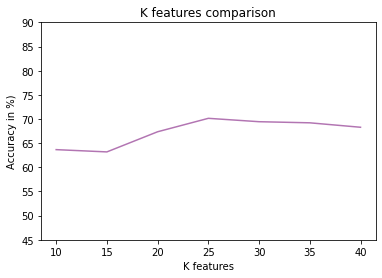

In [217]:
import numpy as np
import matplotlib.pyplot as plt

acc = [63.66, 63.19, 67.36, 70.14, 69.44, 69.21, 68.29]
pt = ['10','15','20','25','30','35','40']
y_pos = np.arange(len(pt))

plt.plot(y_pos, acc, color= (0.5,0.1,0.5,0.6))
plt.title('K features comparison')
plt.xlabel('K features')
plt.ylabel('Accuracy in %)')
plt.ylim(45,90)

plt.xticks(y_pos,pt)
plt.show()
